<a href="https://colab.research.google.com/github/alabyekkubo-ssuubi-brian/Decision_Focused_Model/blob/main/decision_focused_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

# print(os.listdir('/content/drive/MyDrive'))
print(os.listdir('/content/drive/MyDrive/m5_forecast'))


['calendar.csv', 'sales_train_evaluation.csv', 'sales_train_validation.csv', 'sell_prices.csv']


In [3]:


from dataclasses import dataclass, field
from typing import List, Tuple

@dataclass
class Config:
    # Paths
    data_dir: str = "/content/drive/MyDrive/m5_forecast"
    output_dir: str = "/content/drive/MyDrive/m5_forecast/results"

    # Dataset / filtering
    state_filter: str = "CA"     # or "TX", "WI", or "" for all states

    # Feature engineering
    lags: List[int] = field(default_factory=lambda: [1, 7, 28])
    rolling_windows: List[int] = field(default_factory=lambda: [7, 28])

    # Quantiles
    quantiles: Tuple[float, ...] = (0.1, 0.5, 0.9)

    # Model hyperparameters
    hidden_dim: int = 128
    dropout: float = 0.0

    # Training
    batch_size: int = 1024
    learning_rate: float = 1e-3
    epochs_baseline: int = 10
    epochs_decision: int = 10
    epochs_tft: int = 3

    # Decision-focused
    cost_holding: float = 1.0
    cost_shortage: float = 4.0
    lambda_smooth: float = 10.0  # smoothness for softplus

config = Config()




Using device: cuda
Config: Config(data_dir='/content/drive/MyDrive/m5_forecast', state_filter='CA', batch_size=1024, quantiles=(0.1, 0.5, 0.9), epochs_baseline=10, learning_rate=0.001, cost_holding=1.0, cost_shortage=4.0, epochs_tft=5)
Loaded data:
 sales: (30490, 1919)
 calendar: (1969, 14)
 prices: (6841121, 4)
Long-format sales: (58327370, 19)
Feature-engineered sales: (4603990, 30)
Filtered to state CA: (1841596, 31)
Fold 1: Train 2011-03-09 00:00:00 → 2013-05-12 00:00:00 | Test 2013-05-27 00:00:00 → 2014-05-05 00:00:00 (28 days)
Fold 2: Train 2011-03-09 00:00:00 → 2014-05-05 00:00:00 | Test 2014-05-11 00:00:00 → 2015-04-12 00:00:00 (28 days)
Fold 3: Train 2011-03-09 00:00:00 → 2015-04-12 00:00:00 | Test 2015-05-05 00:00:00 → 2016-03-27 00:00:00 (28 days)

Rolling-origin CV defined with 3 × 28-day folds.

=========== FOLD 1/3 ===========
Training baseline quantile model...
[Baseline] Epoch 01 | Train Pinball: 1.1004 | Val Pinball: 0.8681
[Baseline] Epoch 02 | Train Pinball: 0.6727 

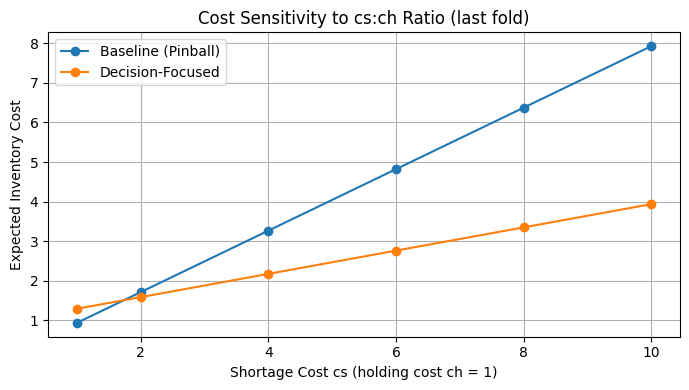


[Warning] pytorch-forecasting / pytorch-lightning not available. Install them in Colab to run the TFT section.
 Error: No module named 'pytorch_forecasting'

Rolling-origin CV notebook finished. Use the fold-wise metrics and their averages as your main empirical evidence in the report.


In [13]:
# Decision-Focused Probabilistic Forecasting on M5
# Aligning Retail Demand Predictions with Inventory Cost Objectives
#
# Designed for Google Colab:
# - Put the M5 files in config.data_dir:
#       sales_train_validation.csv
#       calendar.csv
#       sell_prices.csv
#
# Sections:
#  1. Setup & Imports + Config
#  2. Load M5 Dataset
#  3. Feature Engineering (+ log_demand)
#  4. Rolling-Origin CV Definition (3 × 28-day folds)
#  5. PyTorch Dataset + Training Utilities
#  6. Baseline Quantile Model (Pinball Loss, on log_demand)
#  7. Decision-Focused Model (Newsvendor Loss + Contextual τ(x), log-space, warm-start + multi-task)
#  8. Rolling Evaluation Loop (MASE, RMSSE, Cost, Fill Rate, Stockouts, CRPS)
#  9. Simple Hierarchical Aggregation (Bottom-Up)
# 10. Cost Sensitivity Analysis (cs:ch)
# 11. Temporal Fusion Transformer (TFT) Section (optional)
# 12. Conclusion


# =========================
# 1. Setup & Imports + Config
# =========================

import os
import gc
import math
import random
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)


@dataclass
class Config:
    # Paths
    data_dir: str = "/content/drive/MyDrive/m5_forecast"  # change to your Google Drive path if needed
    state_filter: str | None = "CA"  # set to None to use all states

    # Training / model
    batch_size: int = 1024
    quantiles: tuple = (0.1, 0.5, 0.9)
    epochs_baseline: int = 10
    learning_rate: float = 1e-3

    # Decision-focused costs
    cost_holding: float = 1.0
    cost_shortage: float = 4.0

    # TFT
    epochs_tft: int = 5


config = Config()
print("Config:", config)


# =========================
# 2. Load M5 Dataset
# =========================

DATA_DIR = config.data_dir

sales_path = os.path.join(DATA_DIR, "sales_train_validation.csv")
calendar_path = os.path.join(DATA_DIR, "calendar.csv")
prices_path = os.path.join(DATA_DIR, "sell_prices.csv")

assert os.path.exists(sales_path), "sales_train_validation.csv not found in DATA_DIR"
assert os.path.exists(calendar_path), "calendar.csv not found in DATA_DIR"
assert os.path.exists(prices_path), "sell_prices.csv not found in DATA_DIR"

sales = pd.read_csv(sales_path)
calendar = pd.read_csv(calendar_path)
prices = pd.read_csv(prices_path)

print("Loaded data:")
print(" sales:", sales.shape)
print(" calendar:", calendar.shape)
print(" prices:", prices.shape)


# =========================
# 3. Feature Engineering (+ log_demand)
# =========================

# 3.1 Convert wide -> long
id_cols = [c for c in sales.columns if not c.startswith("d_")]
value_cols = [c for c in sales.columns if c.startswith("d_")]

sales_long = sales.melt(
    id_vars=id_cols,
    value_vars=value_cols,
    var_name="d",
    value_name="demand"
)

# 3.2 Merge with calendar (include wm_yr_wk so we can join prices)
calendar_small = calendar[[
    "d",
    "date",
    "wm_yr_wk",      # key for sell_prices
    "wday",
    "month",
    "year",
    "event_name_1",
    "event_type_1",
    "snap_CA",
    "snap_TX",
    "snap_WI",
]]
sales_long = sales_long.merge(calendar_small, on="d", how="left")

# 3.3 Merge with prices (now wm_yr_wk is present)
sales_long = sales_long.merge(
    prices,
    on=["store_id", "item_id", "wm_yr_wk"],
    how="left"
)

# Ensure date is datetime
sales_long["date"] = pd.to_datetime(sales_long["date"])
sales_long = sales_long.sort_values(["id", "date"]).reset_index(drop=True)

print("Long-format sales:", sales_long.shape)


def add_features(df, lags=(1, 7, 28), rolling_windows=(7, 28)):
    df = df.copy()
    # Temporal features
    df["dayofweek"] = df["date"].dt.dayofweek
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df["month_num"] = df["date"].dt.month

    # Fill and log price (future-proof: use ffill/bfill)
    df["sell_price"] = df["sell_price"].ffill().bfill()
    df["log_price"] = np.log1p(df["sell_price"])

    # Sort for lags/rolling
    df = df.sort_values(["id", "date"])
    group = df.groupby("id", group_keys=False)

    # Lags
    for lag in lags:
        df[f"lag_{lag}"] = group["demand"].shift(lag)

    # Rolling stats
    for window in rolling_windows:
        df[f"rmean_{window}"] = group["demand"].shift(1).rolling(window).mean()
        df[f"rstd_{window}"] = group["demand"].shift(1).rolling(window).std()

    df = df.dropna().reset_index(drop=True)
    return df


sales_fe = add_features(sales_long)
print("Feature-engineered sales:", sales_fe.shape)

# Add log_demand as target for both models
sales_fe["demand"] = sales_fe["demand"].clip(lower=0.0)
sales_fe["log_demand"] = np.log1p(sales_fe["demand"])

# Optional: filter to one state for speed
STATE_FILTER = config.state_filter
if STATE_FILTER is not None:
    sales_fe = sales_fe[sales_fe["state_id"] == STATE_FILTER].reset_index(drop=True)
    print(f"Filtered to state {STATE_FILTER}:", sales_fe.shape)

# Encode simple categorical IDs (do this once, before folds)
for col in ["store_id", "dept_id", "item_id"]:
    sales_fe[col + "_idx"] = sales_fe[col].astype("category").cat.codes


# =========================
# 4. Rolling-Origin CV Definition (3 × 28-day folds)
# =========================

all_dates = np.array(sorted(sales_fe["date"].unique()))
test_horizon = 28
n_folds = 3

folds = []
for k in range(n_folds):
    # For k=0, test is the oldest of the 3 blocks at the end, etc.
    test_start = all_dates[-(n_folds - k) * test_horizon]
    if k < n_folds - 1:
        test_end = all_dates[-(n_folds - k - 1) * test_horizon - 1]
    else:
        test_end = all_dates[-1]

    train_dates = all_dates[all_dates < test_start]
    test_dates = all_dates[(all_dates >= test_start) & (all_dates <= test_end)]

    folds.append({
        "train_dates": train_dates,
        "test_dates": test_dates,
    })

    print(
        f"Fold {k+1}: "
        f"Train {train_dates[0]} → {train_dates[-1]} "
        f"| Test {test_dates[0]} → {test_dates[-1]} "
        f"({len(test_dates)} days)"
    )

print("\nRolling-origin CV defined with 3 × 28-day folds.")


# =========================
# 5. PyTorch Dataset + Training Utilities
# =========================

feature_cols = [
    "dayofweek",
    "weekofyear",
    "month_num",
    "log_price",
    "lag_1",
    "lag_7",
    "lag_28",
    "rmean_7",
    "rstd_7",
    "rmean_28",
    "rstd_28",
]
cat_cols = ["store_id_idx", "dept_id_idx", "item_id_idx"]

# IMPORTANT: target is log_demand (for both baseline & DF models)
target_col = "log_demand"
num_cols = feature_cols


class TabularDataset(Dataset):
    def __init__(self, X, y, ids, dates):
        self.X = X
        self.y = y
        self.ids = ids
        self.dates = dates

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return {
            "features": torch.tensor(self.X[idx], dtype=torch.float32),
            "target": torch.tensor(self.y[idx], dtype=torch.float32),  # log_demand
            "id": self.ids[idx],
            "date": str(self.dates[idx]),
        }


def build_datasets_for_fold(fold, df, batch_size):
    """
    For a given fold:
      - train_dates (outer) for training + validation window
      - test_dates for evaluation
    We further split the outer training dates into:
      - inner train
      - inner validation (last 28 days)
    """
    train_dates_outer = fold["train_dates"]
    test_dates = fold["test_dates"]

    df_trainval = df[df["date"].isin(train_dates_outer)].copy()
    df_test = df[df["date"].isin(test_dates)].copy()

    # inner validation window: last 28 days in trainval
    inner_dates = np.array(sorted(df_trainval["date"].unique()))
    val_window = 28
    if len(inner_dates) > val_window:
        val_start = inner_dates[-val_window]
        inner_train_dates = inner_dates[inner_dates < val_start]
        inner_val_dates = inner_dates[inner_dates >= val_start]
    else:
        # fallback: 80/20 on trainval dates if train history is small
        split_idx = int(0.8 * len(inner_dates))
        inner_train_dates = inner_dates[:split_idx]
        inner_val_dates = inner_dates[split_idx:]

    train_df = df_trainval[df_trainval["date"].isin(inner_train_dates)].copy()
    val_df = df_trainval[df_trainval["date"].isin(inner_val_dates)].copy()

    # scaler fit on numeric cols
    scaler = StandardScaler()
    scaler.fit(train_df[num_cols])

    def preprocess_frame(df_):
        X_num = scaler.transform(df_[num_cols])
        X_cat = df_[cat_cols].values
        X = np.concatenate([X_num, X_cat], axis=1)
        y = df_[target_col].values.astype(np.float32)  # log_demand
        return X.astype(np.float32), y

    X_train, y_train = preprocess_frame(train_df)
    X_val, y_val = preprocess_frame(val_df)
    X_test, y_test = preprocess_frame(df_test)

    train_ds = TabularDataset(
        X_train, y_train,
        train_df["id"].values,
        train_df["date"].values,
    )
    val_ds = TabularDataset(
        X_val, y_val,
        val_df["id"].values,
        val_df["date"].values,
    )
    test_ds = TabularDataset(
        X_test, y_test,
        df_test["id"].values,
        df_test["date"].values,
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return (
        train_df,
        val_df,
        df_test,
        train_loader,
        val_loader,
        test_loader,
        X_train.shape[1],
        y_test,
        df_test["id"].values,
        df_test["date"].values,
    )


# =========================
# 6. Baseline Quantile Model (Pinball Loss, log_demand)
# =========================

def pinball_loss(y_true, y_pred, quantiles):
    """
    y_true: (batch,)  [log_demand]
    y_pred: (batch, n_quantiles)  [log_demand]
    quantiles: list or tensor of length n_quantiles
    """
    q = torch.tensor(quantiles, device=y_pred.device).view(1, -1)
    diff = y_true.unsqueeze(1) - y_pred
    loss = torch.maximum(q * diff, (q - 1.0) * diff)
    return loss.mean()


class QuantileMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, quantiles=(0.1, 0.5, 0.9)):
        super().__init__()
        self.quantiles = quantiles
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, len(quantiles))
        )

    def forward(self, x):
        return self.net(x)


def train_baseline(
    model,
    train_loader,
    val_loader,
    quantiles,
    epochs=config.epochs_baseline,
    lr=config.learning_rate,
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = float("inf")
    best_state = None
    history = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []
        for batch in train_loader:
            x = batch["features"].to(DEVICE)
            y_log = batch["target"].to(DEVICE)  # log_demand

            optimizer.zero_grad()
            preds_log = model(x)  # log-quantiles
            loss = pinball_loss(y_log, preds_log, quantiles)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch in val_loader:
                x = batch["features"].to(DEVICE)
                y_log = batch["target"].to(DEVICE)
                preds_log = model(x)
                loss = pinball_loss(y_log, preds_log, quantiles)
                val_losses.append(loss.item())

        avg_train = float(np.mean(train_losses))
        avg_val = float(np.mean(val_losses))
        history.append((avg_train, avg_val))
        print(f"[Baseline] Epoch {epoch:02d} | Train Pinball: {avg_train:.4f} | Val Pinball: {avg_val:.4f}")

        if avg_val < best_val:
            best_val = avg_val
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)
    return history


# =========================
# 7. Decision-Focused Model (log-space quantiles, warm-start, multi-task)
# =========================

def smooth_max(u, lam=10.0):
    # Softplus-based smooth approximation to max(u, 0)
    return (1.0 / lam) * torch.log1p(torch.exp(lam * u))


class DecisionFocusedMLP(nn.Module):
    """
    Decision-focused MLP that:
    - predicts base quantiles in LOG space
    - interpolates to q_hat_log at contextual tau(x)
    - back-transforms to original demand via expm1
    """

    def __init__(
        self,
        input_dim,
        hidden_dim=128,
        base_quantiles=(0.1, 0.5, 0.9),
        tau_init: float | None = None,
    ):
        super().__init__()
        # Store base quantiles as tensor
        self.register_buffer("base_quantiles", torch.tensor(base_quantiles).view(1, -1))

        # Shared feature extractor
        self.feature_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Head that outputs base quantiles IN LOG SPACE
        self.quantile_head = nn.Linear(hidden_dim, len(base_quantiles))

        # Contextual service level τ(x) in (0,1)
        self.tau_head = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        # Initialise tau around theoretical newsvendor quantile if provided
        if tau_init is not None:
            with torch.no_grad():
                # logit(tau) = log(tau / (1 - tau))
                bias = math.log(tau_init / (1.0 - tau_init))
                self.tau_head[0].bias.fill_(bias)

    def forward(self, x):
        """
        Returns:
        - q_base_log: (batch, Q)  base quantiles in log space
        - tau_ctx:    (batch,)    contextual τ(x)
        """
        h = self.feature_net(x)
        q_base_log = self.quantile_head(h)
        # clamp log-quantiles for numerical stability
        q_base_log = torch.clamp(q_base_log, min=-10.0, max=10.0)

        tau_ctx = self.tau_head(h).squeeze(-1)
        # clamp tau to avoid exactly 0 or 1
        tau_ctx = torch.clamp(tau_ctx, 1e-6, 1.0 - 1e-6)
        return q_base_log, tau_ctx

    def compute_q_hat(self, q_base_log, tau_ctx):
        """
        Interpolate in LOG space to get q_hat_log, then:
        - transform to original demand: q_hat = expm1(q_hat_log)
        - clamp to q_hat >= 0
        """
        device = q_base_log.device
        base_q = self.base_quantiles.to(device)   # (1, Q)
        taus = base_q.squeeze(0)                 # (Q,)
        Q = taus.shape[0]

        # tau_ctx: (batch,)
        tau = tau_ctx.clamp(1e-6, 1.0 - 1e-6)
        batch_size = q_base_log.size(0)

        # Expand to (batch, Q)
        tau_exp = tau.unsqueeze(1).expand(-1, Q)
        taus_exp = taus.unsqueeze(0).expand(batch_size, -1)

        # Masks for bracketing
        le_mask = taus_exp <= tau_exp    # taus <= tau
        ge_mask = taus_exp >= tau_exp    # taus >= tau

        idx_range = torch.arange(Q, device=device).unsqueeze(0).expand(batch_size, -1)

        # lower_idx: largest index j with taus[j] <= tau
        le_idx_masked = torch.where(le_mask, idx_range, torch.zeros_like(idx_range))
        lower_idx = le_idx_masked.max(dim=1).values  # if all False, 0

        # upper_idx: smallest index j with taus[j] >= tau
        ge_idx_masked = torch.where(
            ge_mask,
            idx_range,
            torch.full_like(idx_range, Q - 1)
        )
        upper_idx = ge_idx_masked.min(dim=1).values  # if all False, Q-1

        # ensure ordering
        lower_idx = torch.min(lower_idx, upper_idx)
        upper_idx = torch.max(lower_idx, upper_idx)

        batch_idx = torch.arange(batch_size, device=device)
        lower_q_log = q_base_log[batch_idx, lower_idx]
        upper_q_log = q_base_log[batch_idx, upper_idx]
        lower_tau = taus[lower_idx]
        upper_tau = taus[upper_idx]

        eps = 1e-6
        w = (tau - lower_tau) / torch.clamp(upper_tau - lower_tau, min=eps)
        w = torch.clamp(w, 0.0, 1.0)

        # Interpolated log-quantile
        q_hat_log = lower_q_log + w * (upper_q_log - lower_q_log)

        # Back to original demand space, enforce non-negativity
        q_hat = torch.expm1(q_hat_log)
        q_hat = torch.clamp(q_hat, min=0.0)
        return q_hat


def newsvendor_loss(y_true, q_hat, ch=1.0, cs=4.0):
    """
    Stable Newsvendor loss in ORIGINAL demand space.

    y_true: actual demand (>= 0)
    q_hat:  order quantity from model (>= 0, already clamped)
    ch: holding cost per excess unit
    cs: shortage cost per unit of underage
    """
    q_hat = torch.clamp(q_hat, min=0.0)

    diff = q_hat - y_true
    over = torch.relu(diff)    # overstock
    under = torch.relu(-diff)  # stockout

    cost = ch * over + cs * under
    return cost.mean()


def train_decision_focused(
    model,
    train_loader,
    val_loader,
    ch=1.0,
    cs=4.0,
    epochs=10,
    lr=1e-3,
    alpha=0.3,             # weight on pinball loss (stabilises)
    quantiles=None,
):
    """
    Multi-task training:
    - Train loss = alpha * Pinball(log-space) + (1 - alpha) * NV(original space)
    - Validation monitored on NV only (decision quality).
    """
    if quantiles is None:
        quantiles = config.quantiles

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_nv = float("inf")
    best_state = None
    history = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []

        for batch in train_loader:
            x = batch["features"].to(DEVICE)
            y_log = batch["target"].to(DEVICE)       # log_demand
            y_true = torch.expm1(y_log)              # original demand

            optimizer.zero_grad()
            q_base_log, tau_ctx = model(x)
            q_hat = model.compute_q_hat(q_base_log, tau_ctx)

            # (1) Pinball loss (forecast accuracy in log space)
            pin_loss = pinball_loss(y_log, q_base_log, quantiles)

            # (2) Newsvendor loss (decision loss in original space)
            nv_loss = newsvendor_loss(y_true, q_hat, ch=ch, cs=cs)

            loss = alpha * pin_loss + (1.0 - alpha) * nv_loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_losses.append(loss.item())

        # Validation: monitor pure NV (decision quality)
        model.eval()
        val_nv_losses = []
        with torch.no_grad():
            for batch in val_loader:
                x = batch["features"].to(DEVICE)
                y_log = batch["target"].to(DEVICE)
                y_true = torch.expm1(y_log)

                q_base_log, tau_ctx = model(x)
                q_hat = model.compute_q_hat(q_base_log, tau_ctx)
                nv = newsvendor_loss(y_true, q_hat, ch=ch, cs=cs)
                val_nv_losses.append(nv.item())

        avg_train = float(np.mean(train_losses))
        avg_val_nv = float(np.mean(val_nv_losses))
        history.append((avg_train, avg_val_nv))
        print(f"[DF] Epoch {epoch:02d} | Train MixLoss: {avg_train:.4f} | Val NV: {avg_val_nv:.4f}")

        if not np.isnan(avg_val_nv) and avg_val_nv < best_val_nv:
            best_val_nv = avg_val_nv
            best_state = model.state_dict()

    # Fallback if best_state was never updated (e.g., all NaNs)
    if best_state is None:
        best_state = model.state_dict()

    model.load_state_dict(best_state)
    return history


# =========================
# 8. Rolling Evaluation Loop
# =========================

def predict_baseline(model, loader, quantiles):
    """
    Returns:
      y_true:   original demand (expm1(log_demand))
      q_pred:   predicted quantiles in original demand space
    """
    model.eval()
    all_y, all_q, all_ids, all_dates = [], [], [], []
    with torch.no_grad():
        for batch in loader:
            x = batch["features"].to(DEVICE)
            y_log = batch["target"].to(DEVICE)  # log_demand
            y = torch.expm1(y_log)              # original demand

            preds_log = model(x)                # log-quantiles
            preds = torch.expm1(preds_log)      # original demand quantiles

            all_y.append(y.cpu().numpy())
            all_q.append(preds.cpu().numpy())
            all_ids.append(batch["id"])
            all_dates.append(batch["date"])
    y_true = np.concatenate(all_y)
    q_pred = np.concatenate(all_q)
    ids = np.concatenate(all_ids)
    dates = np.concatenate(all_dates)
    return y_true, q_pred, ids, dates


def predict_decision_focused(model, loader):
    """
    Returns:
      y_true:  original demand
      q_hat:   DF order quantities (original demand)
      tau:     learned service levels
    """
    model.eval()
    all_y, all_qhat, all_tau, all_ids, all_dates = [], [], [], [], []
    with torch.no_grad():
        for batch in loader:
            x = batch["features"].to(DEVICE)
            y_log = batch["target"].to(DEVICE)  # log_demand
            y_true = torch.expm1(y_log)

            q_base_log, tau_ctx = model(x)
            q_hat = model.compute_q_hat(q_base_log, tau_ctx)

            all_y.append(y_true.cpu().numpy())
            all_qhat.append(q_hat.cpu().numpy())
            all_tau.append(tau_ctx.cpu().numpy())
            all_ids.append(batch["id"])
            all_dates.append(batch["date"])

    y_true = np.concatenate(all_y)
    q_hat = np.concatenate(all_qhat)
    tau = np.concatenate(all_tau)
    ids = np.concatenate(all_ids)
    dates = np.concatenate(all_dates)
    return y_true, q_hat, tau, ids, dates


def mase(y_true, y_pred, seasonality=7):
    y = pd.Series(y_true)
    if len(y) <= seasonality:
        return np.nan
    naive = y.shift(seasonality).dropna()
    aligned = y.iloc[seasonality:]
    mae_naive = np.mean(np.abs(aligned.values - naive.values))
    return float(np.mean(np.abs(y_pred - y_true)) / (mae_naive + 1e-8))


def rmsse(y_true, y_pred, seasonality=7):
    y = pd.Series(y_true)
    if len(y) <= seasonality:
        return np.nan
    naive = y.shift(seasonality).dropna()
    aligned = y.iloc[seasonality:]
    mse_naive = np.mean((aligned.values - naive.values) ** 2)
    return float(math.sqrt(np.mean((y_pred - y_true) ** 2) / (mse_naive + 1e-8)))


def decision_metrics(y_true, q, ch=1.0, cs=4.0):
    y_true = np.asarray(y_true)
    q = np.asarray(q)
    over = np.maximum(q - y_true, 0.0)
    under = np.maximum(y_true - q, 0.0)
    cost = ch * over + cs * under
    sales_served = np.minimum(q, y_true)
    fill_rate = float(sales_served.sum() / (y_true.sum() + 1e-8))
    stockouts = float((q < y_true).mean())
    return {
        "expected_cost": float(cost.mean()),
        "fill_rate": fill_rate,
        "stockout_freq": stockouts,
    }


def quantile_trapz_weights(taus):
    taus = np.array(taus)
    Q = len(taus)
    w = np.zeros(Q)
    for k in range(Q):
        if k == 0:
            w[k] = (taus[1] - taus[0]) / 2.0
        elif k == Q - 1:
            w[k] = (taus[-1] - taus[-2]) / 2.0
        else:
            w[k] = (taus[k + 1] - taus[k - 1]) / 2.0
    return w


def crps_from_quantiles(y_true, q_pred, quantiles):
    """
    Approximate CRPS in ORIGINAL demand space,
    given quantiles q_pred (original demand).
    """
    y = np.asarray(y_true).reshape(-1, 1)
    q_pred = np.asarray(q_pred)
    taus = np.array(quantiles).reshape(1, -1)
    diff = y - q_pred
    losses = np.maximum(taus * diff, (taus - 1.0) * diff)
    weights = quantile_trapz_weights(quantiles).reshape(1, -1)
    crps = 2.0 * np.sum(losses * weights, axis=1)
    return float(crps.mean())


def crps_point_mass(y_true, y_pred):
    """
    CRPS for a deterministic forecast equals MAE,
    computed in ORIGINAL demand space.
    """
    return float(np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred))))


baseline_quantiles = config.quantiles
fold_results = []
all_histories = []

for fold_idx, fold in enumerate(folds):
    print(f"\n=========== FOLD {fold_idx+1}/{n_folds} ===========")

    (
        train_df_fold,
        val_df_fold,
        test_df_fold,
        train_loader,
        val_loader,
        test_loader,
        input_dim,
        y_test_true_log,
        ids_test,
        dates_test,
    ) = build_datasets_for_fold(
        fold,
        sales_fe,
        batch_size=config.batch_size,
    )

    # Baseline model (on log_demand)
    baseline_model = QuantileMLP(
        input_dim,
        hidden_dim=128,
        quantiles=baseline_quantiles,
    ).to(DEVICE)
    print("Training baseline quantile model...")
    baseline_history = train_baseline(
        baseline_model,
        train_loader,
        val_loader,
        baseline_quantiles,
        epochs=config.epochs_baseline,
        lr=config.learning_rate,
    )

    # Decision-focused model: warm-start from baseline + tau_init at theoretical τ*
    tau_star = config.cost_shortage / (config.cost_shortage + config.cost_holding)

    df_model = DecisionFocusedMLP(
        input_dim,
        hidden_dim=128,
        base_quantiles=baseline_quantiles,
        tau_init=tau_star,
    ).to(DEVICE)

    # Warm-start weights: copy baseline MLP into DF feature & quantile heads
    with torch.no_grad():
        # baseline.net: [Linear, ReLU, Linear, ReLU, Linear]
        # df_model.feature_net: [Linear, ReLU, Linear, ReLU]
        df_model.feature_net[0].weight.copy_(baseline_model.net[0].weight)
        df_model.feature_net[0].bias.copy_(baseline_model.net[0].bias)
        df_model.feature_net[2].weight.copy_(baseline_model.net[2].weight)
        df_model.feature_net[2].bias.copy_(baseline_model.net[2].bias)
        df_model.quantile_head.weight.copy_(baseline_model.net[4].weight)
        df_model.quantile_head.bias.copy_(baseline_model.net[4].bias)

    print("Training decision-focused model (multi-task: Pinball + NV)...")
    df_history = train_decision_focused(
        df_model,
        train_loader,
        val_loader,
        ch=config.cost_holding,
        cs=config.cost_shortage,
        epochs=config.epochs_baseline,
        lr=config.learning_rate,
        alpha=0.3,
        quantiles=baseline_quantiles,
    )

        # Store histories for plotting later
    all_histories.append({
        "fold": fold_idx + 1,
        "baseline": baseline_history,  # list of (train_pinball, val_pinball)
        "df": df_history,              # list of (train_mixloss, val_nv)
    })


    # Evaluate baseline on this fold (ORIGINAL demand)
    y_test_true_b, q_pred_test, ids_b, dates_b = predict_baseline(
        baseline_model,
        test_loader,
        baseline_quantiles,
    )
    median_pred = q_pred_test[:, 1]  # 0.5 quantile

    baseline_mase = mase(y_test_true_b, median_pred)
    baseline_rmsse = rmsse(y_test_true_b, median_pred)
    baseline_dec = decision_metrics(
        y_test_true_b,
        median_pred,
        ch=config.cost_holding,
        cs=config.cost_shortage,
    )
    baseline_crps = crps_from_quantiles(
        y_test_true_b,
        q_pred_test,
        baseline_quantiles,
    )

    print("\nBASELINE (Pinball, log_demand) – Fold", fold_idx + 1)
    print(f"  MASE:  {baseline_mase:.4f}")
    print(f"  RMSSE: {baseline_rmsse:.4f}")
    print(f"  Expected Cost: {baseline_dec['expected_cost']:.4f}")
    print(f"  Fill Rate:     {baseline_dec['fill_rate']:.4f}")
    print(f"  Stockout Freq: {baseline_dec['stockout_freq']:.4f}")
    print(f"  CRPS:          {baseline_crps:.4f}")

    # Evaluate decision-focused model on this fold (ORIGINAL demand)
    y_df_true, q_hat_test, tau_test, ids_df, dates_df = predict_decision_focused(
        df_model,
        test_loader,
    )
    df_mase = mase(y_df_true, q_hat_test)
    df_rmsse = rmsse(y_df_true, q_hat_test)
    df_dec = decision_metrics(
        y_df_true,
        q_hat_test,
        ch=config.cost_holding,
        cs=config.cost_shortage,
    )
    df_crps = crps_point_mass(y_df_true, q_hat_test)

    print("\nDECISION-FOCUSED (Newsvendor) – Fold", fold_idx + 1)
    print(f"  MASE:  {df_mase:.4f}")
    print(f"  RMSSE: {df_rmsse:.4f}")
    print(f"  Expected Cost: {df_dec['expected_cost']:.4f}")
    print(f"  Fill Rate:     {df_dec['fill_rate']:.4f}")
    print(f"  Stockout Freq: {df_dec['stockout_freq']:.4f}")
    print(f"  CRPS (MAE):    {df_crps:.4f}")

    fold_results.append({
        "fold": fold_idx + 1,
        "baseline_mase": baseline_mase,
        "baseline_rmsse": baseline_rmsse,
        "baseline_cost": baseline_dec["expected_cost"],
        "baseline_fill": baseline_dec["fill_rate"],
        "baseline_stockout": baseline_dec["stockout_freq"],
        "baseline_crps": baseline_crps,
        "df_mase": df_mase,
        "df_rmsse": df_rmsse,
        "df_cost": df_dec["expected_cost"],
        "df_fill": df_dec["fill_rate"],
        "df_stockout": df_dec["stockout_freq"],
        "df_crps": df_crps,
    })

        # Keep last fold’s test data and DF outputs for XAI/visualisations
    if fold_idx == n_folds - 1:
        last_test_df = test_df_fold.copy()
        last_y_df_true = y_df_true.copy()
        last_q_hat_test = q_hat_test.copy()
        last_tau_test = tau_test.copy()
        last_ids_b = ids_b.copy()
        last_dates_b = dates_b.copy()
        last_y_test_true_b = y_test_true_b.copy()
        last_median_pred = median_pred.copy()
        last_ids_df = ids_df.copy()
        last_dates_df = dates_df.copy()


    gc.collect()

fold_results_df = pd.DataFrame(fold_results)
print("\n========== CROSS-FOLD SUMMARY ==========")
print(fold_results_df)

print("\nMEAN OVER 3 FOLDS:")
print(fold_results_df.mean(numeric_only=True))


# =========================
# 9. Simple Hierarchical Aggregation (Bottom-Up)
# =========================
# (Use last fold's baseline predictions as an example)

if len(fold_results) > 0:
    df_baseline_pred = pd.DataFrame({
        "id": ids_b,
        "date": dates_b,
        "y_true": y_test_true_b,
        "q50": median_pred,
    })

    hier = sales_fe[["id", "store_id", "dept_id", "item_id"]].drop_duplicates("id")
    df_baseline_pred = df_baseline_pred.merge(hier, on="id", how="left")

    agg_dept_store = df_baseline_pred.groupby(
        ["store_id", "dept_id", "date"], as_index=False
    )[["y_true", "q50"]].sum()

    print("\nAggregated (store, dept, date) sample:")
    print(agg_dept_store.head())


# =========================
# 10. Cost Sensitivity Analysis (last fold illustration)
# =========================

def cost_sensitivity(y_true, baseline_q, df_qhat, ch=1.0, cs_list=(1, 2, 4, 8, 10)):
    rows = []
    for cs in cs_list:
        base_dec = decision_metrics(y_true, baseline_q, ch=ch, cs=cs)
        df_dec = decision_metrics(y_true, df_qhat, ch=ch, cs=cs)
        rows.append({
            "cs": cs,
            "baseline_cost": base_dec["expected_cost"],
            "df_cost": df_dec["expected_cost"],
        })
    return pd.DataFrame(rows)


if len(fold_results) > 0:
    cs_list = [1, 2, 4, 6, 8, 10]
    sens_df = cost_sensitivity(
        y_test_true_b,
        median_pred,
        q_hat_test,
        ch=1.0,
        cs_list=cs_list,
    )
    print("\nCost sensitivity table (last fold):")
    print(sens_df)

    plt.figure(figsize=(7, 4))
    plt.plot(sens_df["cs"], sens_df["baseline_cost"], marker="o", label="Baseline (Pinball)")
    plt.plot(sens_df["cs"], sens_df["df_cost"], marker="o", label="Decision-Focused")
    plt.xlabel("Shortage Cost cs (holding cost ch = 1)")
    plt.ylabel("Expected Inventory Cost")
    plt.title("Cost Sensitivity to cs:ch Ratio (last fold)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================
# 11. Temporal Fusion Transformer (TFT) Section (optional)
# =========================
# In Colab, first run:
#   !pip install pytorch-lightning pytorch-forecasting --quiet

try:
    from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
    from pytorch_forecasting.metrics import QuantileLoss as TFTQuantileLoss
    from pytorch_lightning import Trainer, seed_everything

    tft_available = True
except Exception as e:
    print("\n[Warning] pytorch-forecasting / pytorch-lightning not available. "
          "Install them in Colab to run the TFT section.")
    print(" Error:", e)
    tft_available = False


if tft_available:
    seed_everything(SEED)

    # Use the LARGEST training window (from the last fold)
    tft_train_dates = folds[-1]["train_dates"]

    tft_df = sales_fe.copy()
    tft_df = tft_df.sort_values("date")
    tft_df["time_idx"] = tft_df["date"].rank(method="dense").astype(int)

    # Reduce number of series for speed (optional)
    N_SERIES = 200
    tmp_train = tft_df[tft_df["date"].isin(tft_train_dates)]
    top_ids = (
        tmp_train.groupby("id")["demand"]
        .sum()
        .sort_values(ascending=False)
        .head(N_SERIES)
        .index
    )
    tft_df = tft_df[tft_df["id"].isin(top_ids)].reset_index(drop=True)

    max_time_idx = tft_df["time_idx"].max()
    training_cutoff = int(0.8 * max_time_idx)

    max_encoder_length = 28   # past context
    max_prediction_length = 7 # forecast horizon

    tft_training = TimeSeriesDataSet(
        tft_df[lambda x: x.time_idx <= training_cutoff],
        time_idx="time_idx",
        target="demand",  # TFT still on original demand
        group_ids=["id"],
        static_categoricals=["id"],
        time_varying_known_reals=["time_idx", "sell_price"],
        time_varying_unknown_reals=["demand"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
    )

    tft_validation = TimeSeriesDataSet.from_dataset(
        tft_training,
        tft_df,
        min_prediction_idx=training_cutoff + 1,
    )

    tft_train_loader = tft_training.to_dataloader(
        train=True,
        batch_size=64,
        num_workers=0
    )
    tft_val_loader = tft_validation.to_dataloader(
        train=False,
        batch_size=64,
        num_workers=0
    )

    tft = TemporalFusionTransformer.from_dataset(
        tft_training,
        learning_rate=1e-3,
        hidden_size=16,
        attention_head_size=1,
        dropout=0.1,
        hidden_continuous_size=8,
        output_size=7,  # number of quantiles
        loss=TFTQuantileLoss(),
        log_interval=10,
        log_val_interval=1,
        reduce_on_plateau_patience=2,
    )

    trainer = Trainer(
        max_epochs=config.epochs_tft,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1,
        enable_model_summary=False,
        gradient_clip_val=0.1,
    )

    print("\nTraining Temporal Fusion Transformer (TFT)...")
    trainer.fit(tft, train_dataloaders=tft_train_loader, val_dataloaders=tft_val_loader)

    raw_predictions, x_tft = tft.predict(tft_val_loader, mode="raw", return_x=True)

    pred_quantiles = raw_predictions["prediction"]
    if isinstance(pred_quantiles, list):
        pred_quantiles = torch.cat(pred_quantiles, dim=0)

    # (N, max_prediction_length, Q)
    tft_q = pred_quantiles[:, 0, :]  # 1-step ahead
    tft_q_np = tft_q.detach().cpu().numpy()

    tft_y = x_tft["decoder_target"][:, 0]  # 1-step ahead true demand
    tft_y_np = tft_y.detach().cpu().numpy()

    q_levels = np.array(tft.loss.quantiles)
    median_idx = np.argmin(np.abs(q_levels - 0.5))
    tft_median = tft_q_np[:, median_idx]

    tft_mase = mase(tft_y_np, tft_median)
    tft_rmsse = rmsse(tft_y_np, tft_median)
    tft_decision = decision_metrics(
        tft_y_np,
        tft_median,
        ch=config.cost_holding,
        cs=config.cost_shortage,
    )
    tft_crps = crps_from_quantiles(tft_y_np, tft_q_np, q_levels)

    print("\nTEMPORAL FUSION TRANSFORMER (TFT) – Validation (1-step ahead)")
    print(f"  MASE:  {tft_mase:.4f}")
    print(f"  RMSSE: {tft_rmsse:.4f}")
    print(f"  Expected Cost: {tft_decision['expected_cost']:.4f}")
    print(f"  Fill Rate:     {tft_decision['fill_rate']:.4f}")
    print(f"  Stockout Freq: {tft_decision['stockout_freq']:.4f}")
    print(f"  CRPS (quantile-based): {tft_crps:.4f}")


# =========================
# 12. Conclusion
# =========================

print("\nRolling-origin CV notebook finished. Use the fold-wise metrics and "
      "their averages as your main empirical evidence in the report.")


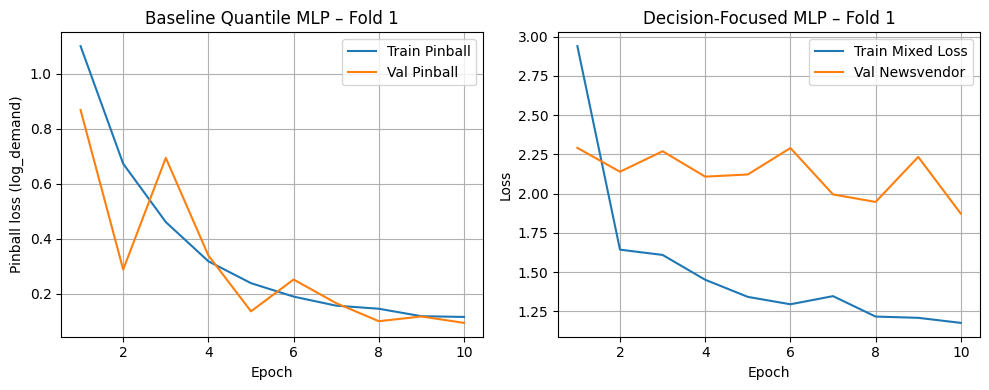

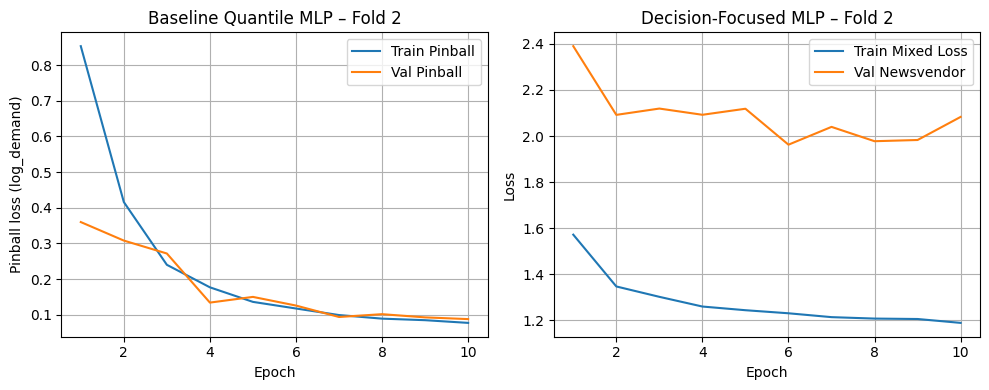

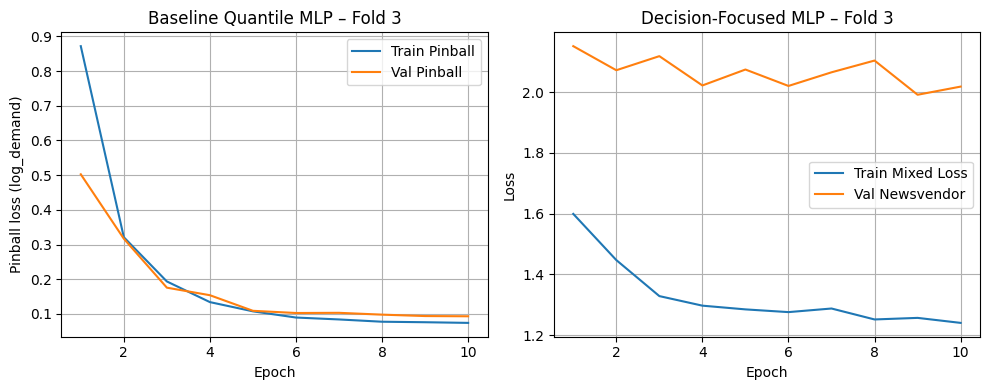

In [14]:
# =========================
# 13.1 Training curves: Baseline vs Decision-Focused
# =========================

def plot_training_curves(all_histories):
    """
    Plots baseline pinball loss and DF mixed/NV loss per epoch, per fold.
    Expects each history entry to be:
      "baseline": [(train_pin, val_pin), ...]
      "df":       [(train_mix, val_nv), ...]
    """
    for h in all_histories:
        fold = h["fold"]
        base_hist = h["baseline"]
        df_hist = h["df"]

        base_train = [t[0] for t in base_hist]
        base_val   = [t[1] for t in base_hist]

        df_train   = [t[0] for t in df_hist]
        df_val_nv  = [t[1] for t in df_hist]

        epochs = range(1, len(base_hist) + 1)

        plt.figure(figsize=(10, 4))

        # Baseline model
        plt.subplot(1, 2, 1)
        plt.plot(epochs, base_train, label="Train Pinball")
        plt.plot(epochs, base_val,   label="Val Pinball")
        plt.xlabel("Epoch")
        plt.ylabel("Pinball loss (log_demand)")
        plt.title(f"Baseline Quantile MLP – Fold {fold}")
        plt.legend()
        plt.grid(True)

        # Decision-focused model
        plt.subplot(1, 2, 2)
        plt.plot(epochs, df_train,  label="Train Mixed Loss")
        plt.plot(epochs, df_val_nv, label="Val Newsvendor")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Decision-Focused MLP – Fold {fold}")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


# Call once after CV loop:
plot_training_curves(all_histories)


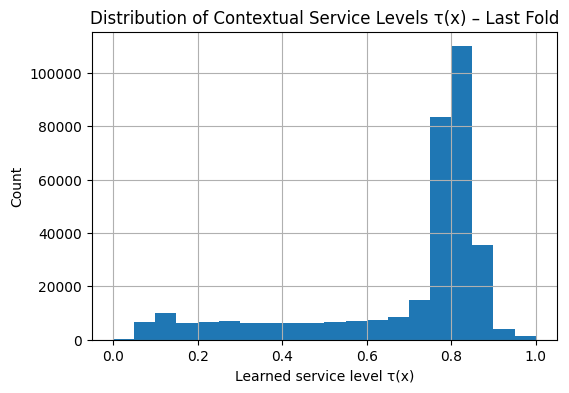

In [15]:
# =========================
# 13.2 τ(x) distribution – last fold
# =========================

plt.figure(figsize=(6, 4))
plt.hist(last_tau_test, bins=20, range=(0, 1))
plt.xlabel("Learned service level τ(x)")
plt.ylabel("Count")
plt.title("Distribution of Contextual Service Levels τ(x) – Last Fold")
plt.grid(True)
plt.show()


/tmp/ipython-input-3043184485.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in df_tau.groupby("price_bin"):


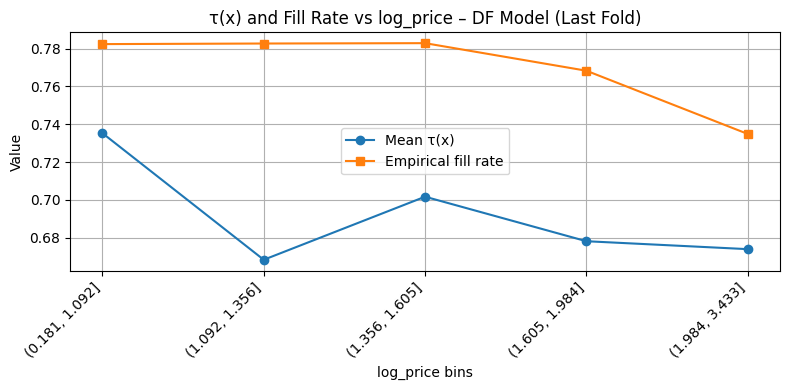

In [16]:
# Attach DF outputs back to last test dataframe
df_tau = last_test_df.copy()
df_tau["tau"]    = last_tau_test
df_tau["y_true"] = last_y_df_true
df_tau["q_hat"]  = last_q_hat_test

# Bin by log_price
df_tau["price_bin"] = pd.qcut(df_tau["log_price"], q=5, duplicates="drop")

rows = []
for b, g in df_tau.groupby("price_bin"):
    sales_served = np.minimum(g["q_hat"], g["y_true"]).sum()
    demand = g["y_true"].sum() + 1e-8
    fill_rate = sales_served / demand
    rows.append({
        "price_bin": b,
        "mean_tau": g["tau"].mean(),
        "fill_rate": fill_rate,
        "count": len(g),
    })

price_groups = pd.DataFrame(rows)

plt.figure(figsize=(8, 4))
idx = np.arange(len(price_groups))
plt.plot(idx, price_groups["mean_tau"], marker="o", label="Mean τ(x)")
plt.plot(idx, price_groups["fill_rate"], marker="s", label="Empirical fill rate")
plt.xticks(idx, price_groups["price_bin"].astype(str), rotation=45, ha="right")
plt.xlabel("log_price bins")
plt.ylabel("Value")
plt.title("τ(x) and Fill Rate vs log_price – DF Model (Last Fold)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


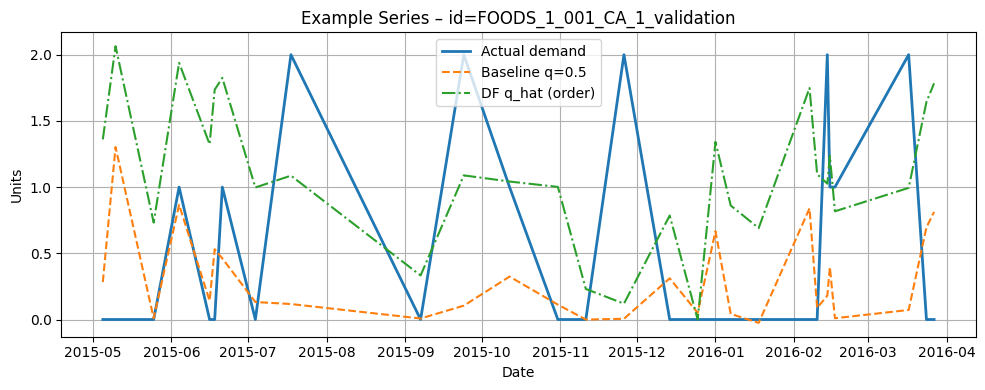

In [17]:
# =========================
# 13.3 Example series plot – last fold
# =========================

def plot_example_series(example_id):
    """
    Plot actual vs baseline-median vs DF q_hat for one item id
    using the last fold's test horizon.
    """
    # Baseline slice
    mask_b = (last_ids_b == example_id)
    dates_b_item = pd.to_datetime(last_dates_b[mask_b])
    y_b_item = last_y_test_true_b[mask_b]
    q50_item = last_median_pred[mask_b]

    # DF slice
    mask_df = (last_ids_df == example_id)
    dates_df_item = pd.to_datetime(last_dates_df[mask_df])
    y_df_item = last_y_df_true[mask_df]
    q_hat_item = last_q_hat_test[mask_df]

    # Sort by date
    order_b = np.argsort(dates_b_item)
    order_df = np.argsort(dates_df_item)

    dates_b_item = dates_b_item[order_b]
    y_b_item = y_b_item[order_b]
    q50_item = q50_item[order_b]

    dates_df_item = dates_df_item[order_df]
    y_df_item = y_df_item[order_df]
    q_hat_item = q_hat_item[order_df]

    plt.figure(figsize=(10, 4))
    plt.plot(dates_b_item, y_b_item, label="Actual demand", linewidth=2)
    plt.plot(dates_b_item, q50_item, label="Baseline q=0.5", linestyle="--")
    plt.plot(dates_df_item, q_hat_item, label="DF q_hat (order)", linestyle="-.")

    plt.xlabel("Date")
    plt.ylabel("Units")
    plt.title(f"Example Series – id={example_id}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Choose an example id from the last fold's test set (you can change this)
example_id = last_ids_b[0]
plot_example_series(example_id)


Baseline MAE on validation (q=0.5): 0.8614
Feature dayofweek: ΔMAE = 0.0050
Feature weekofyear: ΔMAE = 0.0162
Feature month_num: ΔMAE = 0.0027
Feature log_price: ΔMAE = -0.0003
Feature lag_1: ΔMAE = 0.0965
Feature lag_7: ΔMAE = 0.0105
Feature lag_28: ΔMAE = 0.0099
Feature rmean_7: ΔMAE = 0.1660
Feature rstd_7: ΔMAE = -0.0011
Feature rmean_28: ΔMAE = 0.1661
Feature rstd_28: ΔMAE = 0.0199
Feature store_id_idx: ΔMAE = -0.0003
Feature dept_id_idx: ΔMAE = 0.0003
Feature item_id_idx: ΔMAE = 0.0249


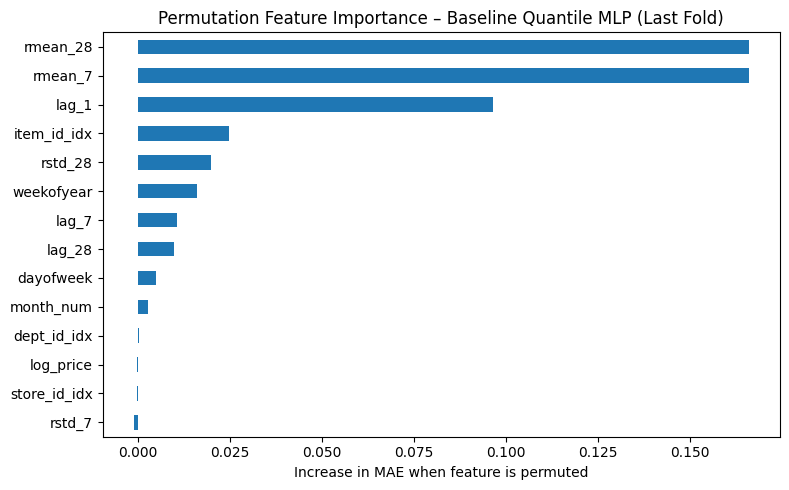

In [18]:
# =========================
# 13.4 Permutation Feature Importance – Baseline Quantile MLP
# (on last fold validation set)
# =========================

feature_names = feature_cols + cat_cols  # numeric + encoded categorical

def collect_from_loader(loader, model, quantiles):
    """
    Collect full X, y, and median predictions from a DataLoader.
    """
    model.eval()
    X_list, y_list, pred_list = [], [], []
    with torch.no_grad():
        for batch in loader:
            x = batch["features"].to(DEVICE)
            y_log = batch["target"].to(DEVICE)
            y_true = torch.expm1(y_log)

            preds_log = model(x)            # (batch, Q)
            preds = torch.expm1(preds_log)  # original space
            median_pred = preds[:, 1]       # q=0.5

            X_list.append(x.cpu().numpy())
            y_list.append(y_true.cpu().numpy())
            pred_list.append(median_pred.cpu().numpy())

    X_all = np.concatenate(X_list)
    y_all = np.concatenate(y_list)
    pred_all = np.concatenate(pred_list)
    return X_all, y_all, pred_all


def mae(y, y_hat):
    return np.mean(np.abs(y - y_hat))


def permutation_importance_baseline(model, loader, feature_names, quantiles):
    """
    Returns a pandas Series with permutation importance scores
    (increase in MAE when the feature is permuted).
    """
    X, y, pred = collect_from_loader(loader, model, quantiles)
    base_mae = mae(y, pred)
    print(f"Baseline MAE on validation (q=0.5): {base_mae:.4f}")

    importances = []
    for j, fname in enumerate(feature_names):
        X_perm = X.copy()
        # Permute column j
        X_perm[:, j] = np.random.permutation(X_perm[:, j])

        with torch.no_grad():
            x_t = torch.tensor(X_perm, dtype=torch.float32, device=DEVICE)
            preds_log = model(x_t)
            preds = torch.expm1(preds_log)
            median_pred = preds[:, 1].cpu().numpy()

        perm_mae = mae(y, median_pred)
        importance = perm_mae - base_mae
        importances.append(importance)
        print(f"Feature {fname}: ΔMAE = {importance:.4f}")

    importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    return importances


baseline_importances = permutation_importance_baseline(
    baseline_model,      # last fold's baseline model
    val_loader,          # last fold's val loader
    feature_names,
    baseline_quantiles,
)

plt.figure(figsize=(8, 5))
baseline_importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.xlabel("Increase in MAE when feature is permuted")
plt.title("Permutation Feature Importance – Baseline Quantile MLP (Last Fold)")
plt.tight_layout()
plt.show()
